### Thinking1
线性规划与混合整数规划的区别是什么？

答：线性规划问题即在线性约束下求解线性目标函数极值的问题，变量取值为实数即可，由于线性函数也属于凸函数，所以针对凸优化问题有较为简单的数学解法；混合整数规划与之不同的是要求部分变量取值必须为整数，因此问题不再是凸优化问题，而此类问题至今没有找到一般的多项式解法，仍然是NP-hard的问题。

### Thinking2
针对VRP问题，常见的约束条件都有哪些？

答：常见的约束条件有每辆车里程的限制，行驶时间、送达时间的限制，车辆承载量的限制，还有各车辆之间分配均衡的限制等。

### Aciton1
Santa的接待安排
圣诞节前100天，Santa开放了workshop，欢迎以家庭单位的参观，如何更合理的安排这些家庭参观？
每个家庭有10个选择choice0-9，数字代表了距离圣诞节的天数，比如 1代表12月24日，每个家庭必须并且只安排一次参观
家庭数量 5000，即family_id 为[0, 4999]，每天访问的人数需要在125-300人
为了更合理的计算Santa的安排能力，我们使用preference cost和accounting penalty两个指标
1）preference cost，代表Santa的个性化安排能力
2）accounting penalty，代表Santa安排的财务成本
每天接待的人员数N(d)如果大于125，就会拥挤，产生过多的清洁成本
最终的 Score = preference cost + accounting penalty
最终提交每个家庭的安排 submission.csv

#### Step1 数据加载

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
# 数据加载
import pandas as pd

data = pd.read_csv('./family_data.csv', index_col='family_id')
data

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4
...,...,...,...,...,...,...,...,...,...,...,...
4995,16,1,66,33,18,70,56,46,86,60,4
4996,88,66,20,17,26,54,81,91,59,48,2
4997,32,66,54,17,27,21,74,81,3,7,6


#### Step2 数据预处理
* 1）计算每个家庭人数 **family_size**
* 2）记录每个家庭的倾向选择(choice_1 ~ choice_10) **desired**
* 3）计算preference cost矩阵 **pcost**
* 4）计算accounting penalty矩阵 **acost**

##### family_size

In [5]:
family_size = data.iloc[:,-1].values
family_size

array([4, 4, 3, ..., 6, 5, 4], dtype=int64)

##### desired

In [6]:
desired = data.values[:,:-1]-1 # 为了之后索引方便1~100 -> 0~99
desired

array([[51, 37, 11, ..., 75,  9, 27],
       [25,  3, 81, ...,  5, 65, 60],
       [99, 53, 24, ..., 88, 79, 32],
       ...,
       [31, 65, 53, ..., 80,  2,  6],
       [66, 91,  3, ..., 11, 25, 69],
       [12, 10, 24, ..., 38, 17, 46]], dtype=int64)

##### pcost

In [7]:
def get_pcost(n, choice): # n代表家庭成员的个数
    cost = None
    if choice == 0:
        cost = 0
    if choice == 1:
        cost = 50
    if choice == 2:
        cost = 50 + n*9
    if choice == 3:
        cost = 100 + n*9
    if choice == 4:
        cost = 200 + n*9
    if choice == 5:
        cost = 200 + n*18
    if choice == 6:
        cost = 300 + n*18
    if choice == 7:
        cost = 300 + n*36
    if choice == 8:
        cost = 400 + n*36
    if choice == 9:
        cost = 500 + n*(36+199)
    if choice > 9:
        cost = 500 + n*(36+398)
    return cost

In [8]:
%%time
n_days = 100 # 安排的天数
n_families = 5000 # 家庭个数
min_occupancy = 125 # 最小承载量
max_occupancy = 300 # 最大承载量

# 计算不同家庭不同日期到访的pcost
import numpy as np

pcost = np.zeros((5000,100))
for f in range(n_families):
    f_num = family_size[f]
    # 初始化，默认都是choice_10(otherwize)
    pcost[f,:] = get_pcost(f_num, 10)
    for choice in range(10):
#         day = data.loc[f][choice]     # 用data.loc要5s
#         pcost[f,day-1] = get_pcost(f_num, choice)
        day = desired[f][choice]
        pcost[f,day] = get_pcost(f_num, choice)
pcost

Wall time: 76 ms


array([[2236., 2236., 2236., ..., 2236., 2236., 2236.],
       [2236., 2236., 2236., ..., 2236., 2236., 2236.],
       [1802., 1802., 1802., ..., 1802., 1802.,    0.],
       ...,
       [3104., 3104.,  616., ..., 3104., 3104., 3104.],
       [ 390., 2670., 2670., ..., 2670., 2670., 2670.],
       [2236., 2236., 2236., ..., 2236., 2236., 2236.]])

##### acost

In [41]:
%%time
# 每天0~300个人
acost = np.zeros(shape=(max_occupancy+1-125, max_occupancy+1-125), dtype=np.float64) # float64计算更精确
for i in range(acost.shape[0]): # 当天安排的人数
    for j in range(acost.shape[1]): # 前一天安排的人数
        diff = abs(i-j)
        acost[i][j] = max(0, i/400 * (i+125)**(1/2 + diff/50))
acost

Wall time: 36 ms


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.09123977e-02, 2.80624304e-02, 3.09123977e-02, ...,
        4.71411265e+05, 5.19286901e+05, 5.72024695e+05],
       [6.83949464e-02, 6.20794612e-02, 5.63471383e-02, ...,
        8.82837130e+05, 9.72650165e+05, 1.07160008e+06],
       ...,
       [2.71570454e+09, 2.42324984e+09, 2.16228964e+09, ...,
        7.46610759e+00, 8.36716954e+00, 9.37697794e+00],
       [3.10213423e+09, 2.76787940e+09, 2.46964050e+09, ...,
        8.43020770e+00, 7.52185316e+00, 8.43020770e+00],
       [3.54375000e+09, 3.16169994e+09, 2.82083852e+09, ...,
        9.51970597e+00, 8.49339085e+00, 7.57772228e+00]])

#### Step3 求解LP/MIP
* 1）使用LP对大部分家庭进行规划
* 2）使用MIP对剩余家庭进行规划
* 3）汇总结果

In [57]:
from ortools.linear_solver import pywraplp
# 线性规划
def solveLP(families, Type='LP', Min=min_occupancy, Max=max_occupancy, n=25): # n为人为约束的前后两天人数浮动范围
    if Type == 'LP':
        solver= pywraplp.Solver('AssignmentProblem', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    if Type == 'MIP':
        solver = pywraplp.Solver('AssignmentProblem', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    
    x = {} # family_id在j天是否参观
    # 每一天有哪些家庭
    candidates = [[] for x in range(n_days)]
    for i in families:
        for j in desired[i,:]:
#         for j in range(n_days):
            candidates[j].append(i)
            # 定义变量
            x[i,j] = solver.BoolVar('x[%i, %i]' % (i,j))
#             print(x)
    
    # 每天参观人数
    daily_occupancy = [solver.Sum([x[i, j] * family_size[i] for i in candidates[j]]) for j in range(n_days)]
    
    # 每个家庭在desired中的参观总次数
    family_presence = [solver.Sum([x[i,j] for j in desired[i,:]]) for i in families]
    
    # 定义目标函数
    preference_cost = solver.Sum([x[i,j] * pcost[i,j] for i in families for j in desired[i,:]])
    
    # 目标是最小化目标函数
    solver.Minimize(preference_cost)
    
    #约束条件
    # 人为增加约束条件
    for j in range(n_days-1):
        # 当前人数比前一天浮动在n以内（由于acost计算涉及前后差值的指数级）
        solver.Add(daily_occupancy[j] - daily_occupancy[j+1] <= n)
        solver.Add(daily_occupancy[j+1] - daily_occupancy[j] <= n)

    # 每个家庭有且只有一次参观
    for i in range(len(family_presence)):
        solver.Add(family_presence[i] == 1)
    
    # 每天参观人数125~300
    if type(Min) is int:
        Min = [Min]*n_days
    if type(Max) is int:
        Max = [Max]*n_days
    for j in range(n_days):
        solver.Add(daily_occupancy[j] >= Min[j])
        solver.Add(daily_occupancy[j] <= Max[j])
    
    # 求解
    result = solver.Solve()
    
    # 得到参观日期安排
    temp = [(i, j, x[i,j].solution_value()) for i in families\
            for j in desired[i,:] if x[i,j].solution_value() > 0]
    print(solver.Objective().Value())
    df = pd.DataFrame(temp, columns=['family_id','day','result'])
    return df

In [58]:
def solve_santa(n_1, n_2=float('inf'), thre=0.99):
    # LP安排大部分
    all_families = list(range(n_families))
    result = solveLP(all_families, Type='LP', n=n_1)
    assigned_df = result[result.result > thre]
    assigned_df['family_size'] = family_size[assigned_df.family_id]
    occupancy = assigned_df.groupby('day').family_size.sum().values
    
    # MIP安排余下未安排好的
    min_rest = np.maximum(0, min_occupancy-occupancy)
    max_rest = max_occupancy - occupancy
    rest_family = [i for i in range(n_families) if i not in assigned_df.family_id.values]
    rest = solveLP(rest_family, Type='MIP', Min=min_rest, Max=max_rest, n=n_2)
    final_result = pd.concat((assigned_df[['family_id', 'day']], rest[['family_id', 'day']]))
    return final_result

In [59]:
%%time
final = solve_santa(n_1=25, thre=0.99)

73702.31696428571
1401.0
Wall time: 10.5 s


#### Step4 结果评估与呈现

In [99]:
from numba import jit
# 根据安排计算cost
@jit
def Pcost(prediction):
    cost = 0
    daily_occupancy = np.zeros(n_days, dtype=np.int64)
    for i,d in prediction.values:
        cost += pcost[i][d]
        n = family_size[i]
        daily_occupancy[d] += n
    return cost, daily_occupancy

@jit
def Acost(daily_occupancy):
    cost = 0
    for j in range(n_days-1):
        if daily_occupancy[j]<125 or daily_occupancy[j]>300\
        or daily_occupancy[j+1]<125 or daily_occupancy[j+1]>300:
            return float('inf')
        else:
            cost += acost[daily_occupancy[j]-125, daily_occupancy[j+1]-125]
#             cost += acost[daily_occupancy[99]-125, 0] # 假设第101天不营业，即参观人数为0,导致cost太大
    return cost

@jit
def cost_function(prediction):
    p, daily_occupancy = Pcost(prediction)
    a = Acost(daily_occupancy)
    cost = p + a
    return cost

In [61]:
import matplotlib.pyplot as plt
def plot_daily(prediction):
    result = prediction.copy()
    result['family_size'] = family_size[result.family_id]
    daily_occupancy = result.groupby('day').family_size.sum()
    plt.bar(daily_occupancy.index,daily_occupancy.values, width=0.5, color='orange')
    plt.xlabel('day')
    plt.ylabel('counts')
    plt.show()

In [76]:
sum_cost = cost_function(final)
sum_cost

77596.69049325124

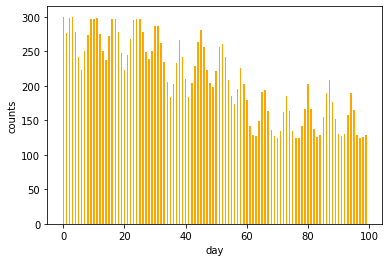

In [63]:
plot_daily(final)

#### Step5 优化方案

In [100]:
@jit
def find_better(prediction):
    sorted_families = np.argsort(-family_size) # 按人数对家庭进行排序
    score = cost_function(prediction)
    original_score = np.inf
    pred = prediction.set_index('family_id')['day']
    
    while score < original_score:
        original_score = score
        
        for i in sorted_families:
            for option in range(10):
                day = desired[i, option]
                oldday = pred[i]
                pred[i] = day
                prediction = pred.reset_index()
                newscore = cost_function(prediction)
                if newscore < score:
                    score = newscore
                else:
                    pred[i] = oldday
                    prediction = pred.reset_index()
                print(score, end='\r')
    print(score)
    return prediction

In [426]:
%%time
better = find_better(final)

66649.87134510679
Wall time: 1h 1min 4s


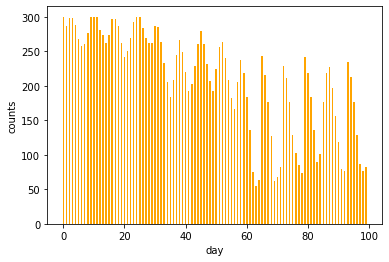

In [432]:
plot_daily(better)

上图为上次作业的结果，后期出现了访问人数不足125的情况，对acost计算函数进行修正后结果如下

In [101]:
%%time
better = find_better(final)

73305.94721120875
Wall time: 17min 11s


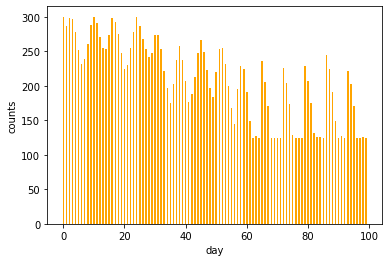

In [102]:
plot_daily(better)

In [435]:
def save_result(prediction, filename):
    pred = prediction.copy()
    pred['day'] = pred['day'] + 1
    pred.rename(columns = {'day': 'assigned_day'}, inplace=True)
    pred.to_csv(filename, index=False)
    print(filename + ' saved')
save_result(better, 'subnission.csv')

subnission.csv saved


### Aciton2
多辆车的路径规划 VRP：
条件：经过中国33个城市，一共4辆车，每辆车最大行驶10000公里
目标：使得每辆车的行驶里程数更接近  
需要注意：  
1）在VRP问题中，路径上给点赋的index和点实际的index不一样，需要使用IndexToNode方法进行转换才能得到实际的index

In [158]:
import pandas as pd
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

class tsp(object):
    def __init__(self, selected_city=None, num_vehicles=1): # selected_city传入所选城市的list
        self.df = pd.read_excel('./distance.xlsx', index_col=0)
        self.num_vehicles = num_vehicles
        if selected_city:
            self.cities = selected_city
            self.distance = self.df[selected_city].loc[selected_city].values
        else:
            self.cities = self.df.index.values
            self.distance = self.df.values
    
    # 设置数据
    def create_data_model(self):
        data = {}
        # 城市之间的距离(邻接矩阵，单位千米)
        data['distance_matrix'] = self.distance/1000
        data['num_vehicles'] = self.num_vehicles
        data['depot'] = 0 # 下标
#         print(data)
        return data
    
    def print_solution(self, manager, routing, solution):
#         print('总行驶里程：{} 公里'.fomat(solution.ObjectiveValue()))
        # 记录每辆车的里程，路径
        distance_list = []
        route_list = []
        for i in range(self.num_vehicles):
            route_distance = 0
            route = []
            index = routing.Start(i)
            while not routing.IsEnd(index):
                # indextonode将manager中的index转化为邻接矩阵中的index
                real_index = manager.IndexToNode(index)
                route.append(self.cities[real_index])
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
            route.append(route[0])
            route_list.append(route)
            distance_list.append(route_distance)
        return route_list, distance_list
    
    # 添加距离约束
    def add_distance_dimention(self, routing, transit_callback_index):
        dimension_name = 'Distance'
        routing.AddDimension(
            transit_callback_index,
            0,  # no slack
            10000,  # 车辆最大行驶距离
            True,  # start cumul to zero
            dimension_name)
        distance_dimension = routing.GetDimensionOrDie(dimension_name)
        # 尽量减少车辆之间的最大距离
        distance_dimension.SetGlobalSpanCostCoefficient(100)
    
    def work(self):
        # 初始化数据
        data = self.create_data_model()
     
        # 创建路线管理，tsp_size（城市数量）, num_vehicles（车的数量）, depot（原点）
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                               data['num_vehicles'], data['depot'])
     
        # 创建 Routing Model.
        routing = pywrapcp.RoutingModel(manager)
        
        # 计算两点之间的距离
        def distance_callback(from_index, to_index):
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data['distance_matrix'][from_node][to_node]
        
        # 注册距离函数
        transit_callback_index = routing.RegisterTransitCallback(distance_callback)
     
        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
        
        # 添加距离维度的限制
        self.add_distance_dimention(routing, transit_callback_index)
     
        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
     
        # 求解路径规划
        solution = routing.SolveWithParameters(search_parameters)
        # 输出结果
        if solution:
            route_list, distance_list = self.print_solution(manager, routing, solution)
            return route_list, distance_list
    

In [159]:
if __name__ == '__main__':
    model = tsp(num_vehicles=4)
    route_list, distance_list = model.work()
    total_distance = 0
    for i,j in enumerate(zip(route_list, distance_list)):
        total_distance += j[1]
        print('路径{}： {}\n里程为{}公里'.format(i+1, ('=>').join(j[0]), j[1]))
    print('总路程：{}公里'.format(total_distance))

路径1： 北京=>太原=>银川=>西宁=>兰州=>乌鲁木齐=>呼和浩特=>北京
里程为6341公里
路径2： 北京=>拉萨=>北京
里程为7096公里
路径3： 北京=>石家庄=>西安=>成都=>重庆=>贵阳=>昆明=>南宁=>海口=>澳门=>广州=>香港=>南昌=>合肥=>济南=>北京
里程为6749公里
路径4： 北京=>郑州=>武汉=>长沙=>福州=>杭州=>上海=>南京=>天津=>沈阳=>哈尔滨=>长春=>北京
里程为6845公里
总路程：27031公里
